線型回帰モデルの訓練方法


*   「閉形式の方程式」
*   勾配降下法（GD:gradient descent)


線形モデル：入力特徴量の加重総和に、バイアス項(bias term)という定数を加えたもの\
パラメータベクトル（parameter vector)：バイアス項と特徴量の重み\
特徴量ベクトル（feature vector)：特徴量の値



閉形式解(closed-form solution)：結果を直接与えてくれる方程式→正規方程式（normal equation)

In [1]:
import numpy as np

X = 2 * np.random.rand(100,1)#xは0~2のランダムの実数100個
y = 4+3*X + np.random.randn(100,1) #y=4+3x

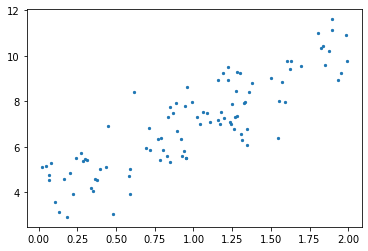

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X,y,s=5)
plt.show()

正規方程式の導出

https://manabitimes.jp/math/1128

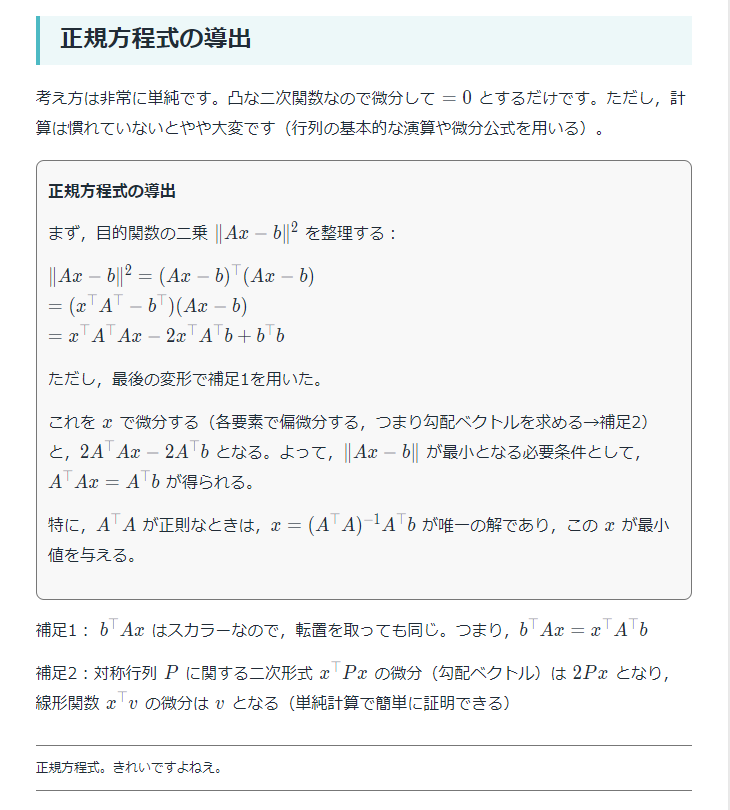

In [3]:
X_b = np.c_[np.ones((100,1)), X] #各インスタンスにx₀＝1を加える
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
theta_best

array([[3.84091329],
       [3.19664593]])

In [5]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.84091329],
       [10.23420516]])

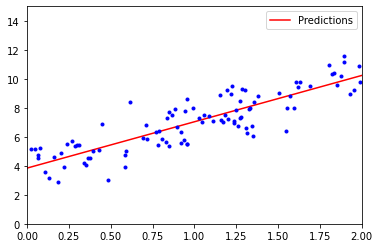

In [6]:
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.legend()
plt.show()

https://note.com/sayajewels/n/n95edaedb0fc5

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([3.84091329]), array([[3.19664593]]))

In [8]:
lin_reg.predict(X_new)

array([[ 3.84091329],
       [10.23420516]])

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[3.84091329],
       [3.19664593]])

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[3.84091329],
       [3.19664593]])

https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNRpsRhXTMt8uJdIGz9-X_1-&index=1
特異値分解について


$(n+1)\times(n+1)$の行列の、$X^TX$の逆行列を計算するときの計算量は$O(n^{2.4})\sim O(n^3)$

勾配降下法(gradient)：損失関数を最小にするために、パラメータを繰り返し操作する
ランダム初期化(random initialization)：無作為な値でパラメータを初期化すること

勾配降下法の2大難題
* 全体の最小値よりも見劣りのする局所的な最小値で収束する
* 台地を通り過ぎるために非常に長い時間がかかる

MSE損失関数はリプシッツ連続

勾配降下法を使う時には、すべての特徴量が同じようなスケールになるようにする。

バッチ勾配降下法（batch gradient descent)：ステップごとに、訓練データ全体のバッチを使う勾配降下法\
$\eta\nabla_\theta MSE(\theta)=\frac{2}{m}X^T(X\theta-y)$\
$\theta^{(next step)} = \theta - \eta\nabla_\theta MSE(\theta)$

In [11]:
eta = 0.1
n_iter = 1000
m = 100
theta = np.random.randn(2,1)

for iter in range(n_iter):
    grad = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta * grad

theta

array([[3.84091329],
       [3.19664593]])

よい学習率を見つけるためには、グリッドサーチを使う。このとき、時間がかかってなかなか収束しないモデルを取り除けるように、反復回数に制限をかける。\
➡反復回数を非常に大きく設定しつつ、勾配ベクトルが小さくなったら、アルゴリズムを中止する。

**確率的勾配降下法（stochastic gradient descent:SGD)**：各ステップで訓練セットから無作為に１つのインスタンスを選び出し、そのインスタンスだけを使って勾配を計算する。
・バッチ勾配降下法に比べて高速\
・巨大な訓練セットで訓練できる\
・確率的な性質を持つため、損失関数は上下に動きながら、平均的に減っていく→1か所に落ちつくことがない\
➡最小値の外に飛びやすくなるため、全体の最小値を見つけられる確率は上がるが、最小値に落ち着かない可能性がある。\
➡学習率を少しずつ小さくする＝焼きなまし法（simulated annealing)/学習スケジュール(learning schedule)


In [12]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t+t1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)#100個の中から一つのインデックスを選ぶ
        xi = X_b[random_index:random_index+1]#インスタンス抽出
        yi = y[random_index: random_index+1]
        grad = 2* xi.T.dot(xi.dot(theta)-yi)#勾配計算(m=1)
        eta = learning_schedule(epoch * m + i)
        theta  = theta - eta * grad

theta

array([[3.88969417],
       [3.15129724]])

確率的勾配降下法を使う時には、パラメータが平均的に全t内の最適地に近づいていくように、訓練インスタンスは独立同分布（IID:independent and identically distributed)になっていなけらばならない。\
➡訓練中にインスタンスをシャッフルする

In [13]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.87795777]), array([3.27504562]))

**ミニバッチ勾配降下法（mini-batch gradient descent)**:各ステップでミニバッチ（mini-batch)と呼ばれる無作為に選んだインスタンスの小さな集合を使って勾配を計算する。\
*　ＧＰＵを使ったときに、行列演算のハードウェアによる最適化を利用してパフォーマンスを引き上げられる
*　局所的なさいしょうちからは逃れにくくなる。

**多項式回帰（polynomial regression)**


In [26]:
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)

print(X[0], X_poly[0])

[1.55642861] [1.55642861 2.42247003]


https://www.youtube.com/watch?v=TKnpSD1X_gY polynomial features

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.29284948]), array([[0.97075432, 0.41126151]]))

適合の評価方法
* 交差検証（2章）
* 学習曲線（learning curve)：訓練セット、検証セットに対する性能をプロットしたもの。

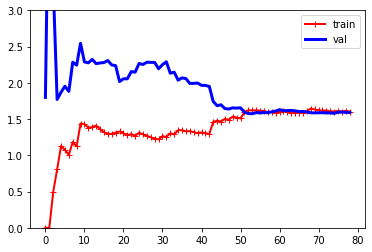

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth = 2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.ylim(0,3)
    plt.legend()
    plt.show()
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

過少適合モデルの典型的な例：両方の曲線が一定の水準に達し、ともに近接しているが、全体として誤差が大きい。\
過少適合しているときは、訓練データを追加しても役にたたない➡より複雑なモデルを使うか、よりよい特徴量を用意する

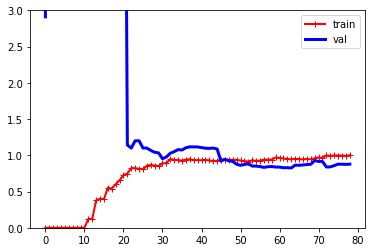

In [17]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias = False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

過学習の特徴
* 訓練誤差が小さい
* ２つの曲線の間に大きな差がある

➡訓練データを増やすのも一つの方法

モデルの汎化誤差
* バイアス(bias)：前提条件のまずさに起因、バイアスの高いモデルは訓練データに対して過小適合しやすい
* 分散(variance)：データの小さな際に敏感すぎることに起因、自由度（degrees of freedom)が高いモデルは分散が高くなりがちであり、訓練データを過学習しやすい。
* 削減不能誤差（irreducable error)：データ自体のノイズに起因。データのクリーンアップが必要（データソースの修理、外れ値の検出と除去など）

**Ridge回帰（ridge regression)**:損失関数に正則加工（regularization term)を加える。\
$J(\theta) = MSE(\theta)+\alpha\frac{1}{2}\Sigma_{i=1}^n{\theta_i^2}$\
学習アルゴリズムは、データに適合するだけでなく、モデルの重さをできる限り小さく保たなければならない！

閉形式の式の計算でも勾配降下法による訓練でも実行できる。

In [18]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.12193017]])

In [19]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.10878065])

**Lasso回帰**：Least Abusolute Shrinkage and Selection Operator Regression\
$J(\theta) = MSE(\theta)+\alpha\Sigma_{i=1}^n{|\theta_i|}$\
○重要な特徴\
重要性の低い特徴量の重みを完全に取り除いてしまう傾向がある。＝自動的に特徴量を選択し疎なモデル（sparse model: 0以外の重みをもつ特徴量がほとんどないもモデル）を出力する\
∵全パラメータが同じように小さくなっていく➡どんどん０になっていく
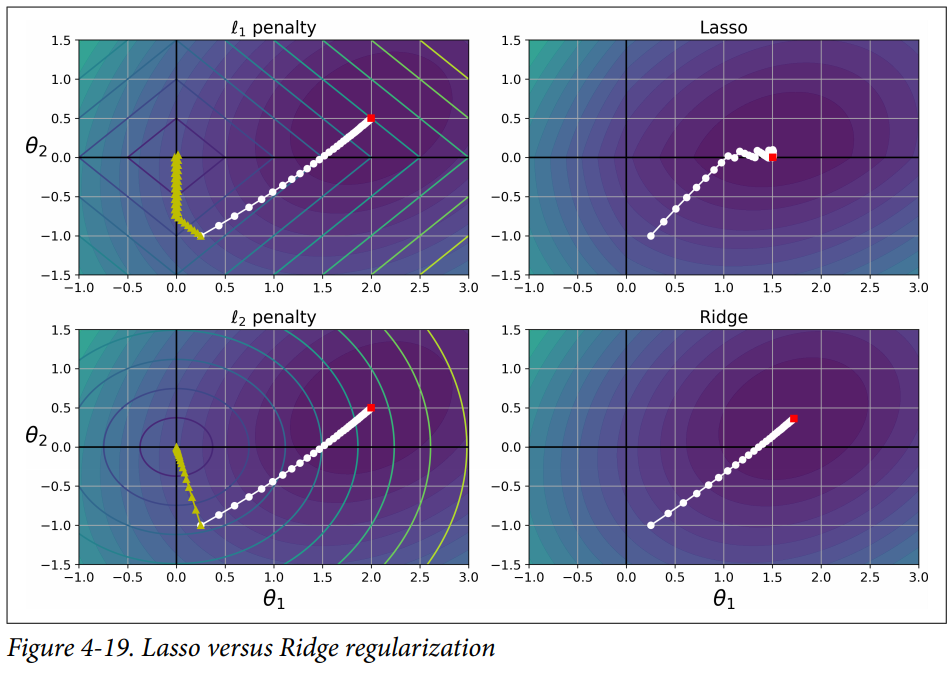\
Lasso損失関数は$\theta_i=0 (i=1,2,...,n)$で微分可能でない\
$g(\theta, J) = \nabla_\theta MSE(\theta) + \alpha
\begin{pmatrix}
sign(\theta_1) \\
sign(\theta_2) \\
\vdots\\
sign(\theta_n)
\end{pmatrix} \: where \: sign(\theta_i) = \left\{ \,
    \begin{aligned}
    & -1 \quad if \: \theta_i<0  \\
    & 0 \quad if \: \theta_i=0 \\
    & +1 \quad if \: \theta_i>0 
    \end{aligned}
\right.
$

In [20]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.08277487])

**Elastic Net**:Ridge回帰とLasso回帰の中間→混ぜ方は割合ｒで変えられる。（r=0でRidge回帰, r=1でLasso回帰）\
$g(\theta, J) = \nabla_\theta MSE(\theta) + r\alpha\Sigma_{i=1}^n{|\theta_i|} + \frac{1-r}{2}\alpha\Sigma_{i=1}^n{\theta_i^2}$\
正則化の使い分け
* 線型回帰は避けたほうが良い。
* 意味がある特徴量は一部だけなのではないかと疑われるときには、LassoやElastic Net
* 訓練インスタンスの数よりも特徴量の数のほうが多いときや、複数の特徴量の間に強い関係があるときにElastic Net

In [21]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio = 0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([5.0840579])

**早期打ち切り（early stopping)**：検証誤差が最小になったところで、訓練を中止する。

In [31]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
import numpy as np

X = 2 * np.random.rand(100,1)#xは0~2のランダムの実数100個
y = 4+3*X + np.random.randn(100,1) #y=4+3x
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_poly_scaled=poly_scaler.fit_transform(X_train)
X_val_poly_scaled=poly_scaler.transform(X_val)

print(y_val, y_val.ravel())
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error=float("inf")
best_epoch=None
best_model=None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())#y_train.ravel()にしないとerrorが出る
    y_val_predict=sgd_reg.predict(X_val_poly_scaled)
    val_error=mean_squared_error(y_val, y_val_predict)
    if val_error<minimum_val_error:
        minimum_val_error=val_error
        best_epoch=epoch
        best_model=clone(sgd_reg)

print(best_epoch)

[[ 6.68359492]
 [ 5.63438264]
 [ 5.83624331]
 [ 6.87516477]
 [ 9.02602038]
 [ 7.60234885]
 [11.62774982]
 [ 7.23044434]
 [ 8.63211344]
 [ 6.34963127]
 [ 5.4101738 ]
 [ 8.38949441]
 [ 6.33902153]
 [ 8.40607387]
 [ 9.89330362]
 [ 7.45677656]
 [ 6.77912652]
 [10.50079011]
 [ 8.4372553 ]
 [ 5.14289322]] [ 6.68359492  5.63438264  5.83624331  6.87516477  9.02602038  7.60234885
 11.62774982  7.23044434  8.63211344  6.34963127  5.4101738   8.38949441
  6.33902153  8.40607387  9.89330362  7.45677656  6.77912652 10.50079011
  8.4372553   5.14289322]
116


**ロジスティック回帰（logistic regression)/ロジット回帰(logit regression)：**

$\sigma(t) = \frac{1}{1+\exp(-t)}$\
スコアｔはよくロジット（logit)と呼ばれる。\
$logit(p) = \log(\frac{p}{1-p})$...ロジット関数＝ロジスティック関数の逆関数\
➡ロジットは陽性クラスの推定確率と陰性クラスの推定確率の比の対数➡対数オッズ（log-odds)

ロジスティック回帰の損失関数
$J(\theta) = - \frac{1}{m} \Sigma_{i=1}^m[y^{(i)}\log(\hat{p}^{(i)})+(1-y^{(i)})\log(1-\hat{p}^{(i)})]$

損失関数の偏微分も求められる。

In [33]:
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))
X=iris["data"][:, 3:]
y=(iris["target"]==2).astype(np.int)

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']


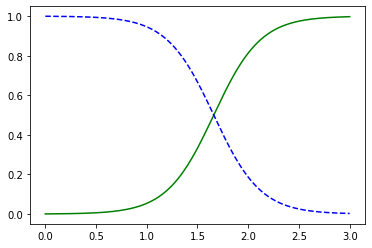

In [34]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

X_new=np.linspace(0,3,1000).reshape(-1,1)
y_proba=log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

https://qiita.com/yosshi4486/items/deb49d5a433a2c8a8ed4
numpyのreshape(-1)とは？

決定境界（decision boundary):両方の確率がともに50％になる

In [35]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

ソフトマックス回帰（softmax regression)/多項ロジスティック回帰（multinomial logistic regression):複数のクラスをサポートするように一般化したロジスティック回帰

ソフトマックス関数（softmax function)/正規化指数関数（normalized exponential function)

$\hat{p}_k = \frac{\exp(s_k(x))}{\Sigma_{j=1}{K}\exp(s_j(x))}$

ソフトマックス回帰分類器は、1度に1つのクラスだけを予測する

交差エントロピー（cross entropy):一連のクラスに対して推計された確率がターゲットクラスにどれくらい適合するかを示す\

$J(\Theta) = -\frac{1}{m}\Sigma_{i=1}^m\Sigma_{k=1}^Ky_k^{(i)}\log(\hat{p}_k^{(i)})$

https://www.youtube.com/watch?v=ErfnhcEV1O8 \
なぜ「エントロピー（乱雑さ）」に相当するのか天気の例で解説されていた

In [38]:
X = iris["data"][:, (2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

print(softmax_reg.predict([[5,2]]))
print(softmax_reg.predict_proba([[5,2]]))                                

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]
